In [53]:
#Were some states worse off than others? I.e. could we resume operations in one state, but not in another? Could we group the states into high medium and
#low risk?

Dataset shape: (10479, 6)
Agglomerative Clustering Silhouette Score: 0.35460127420378384


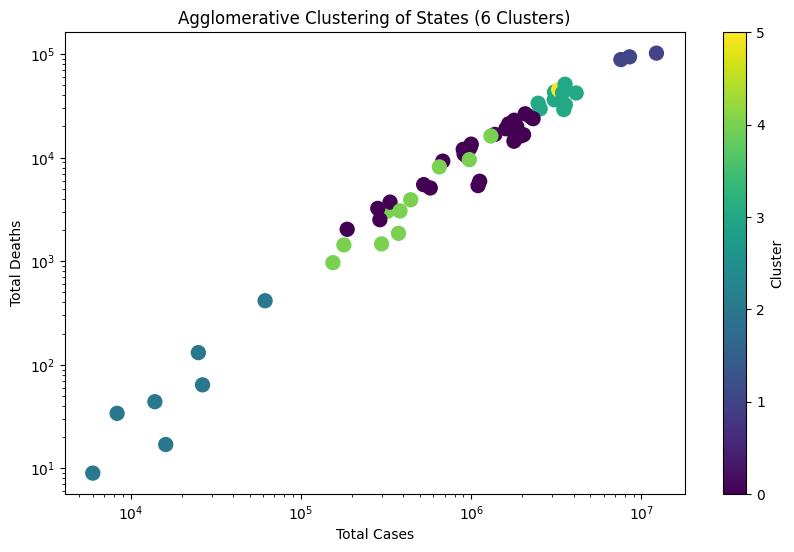

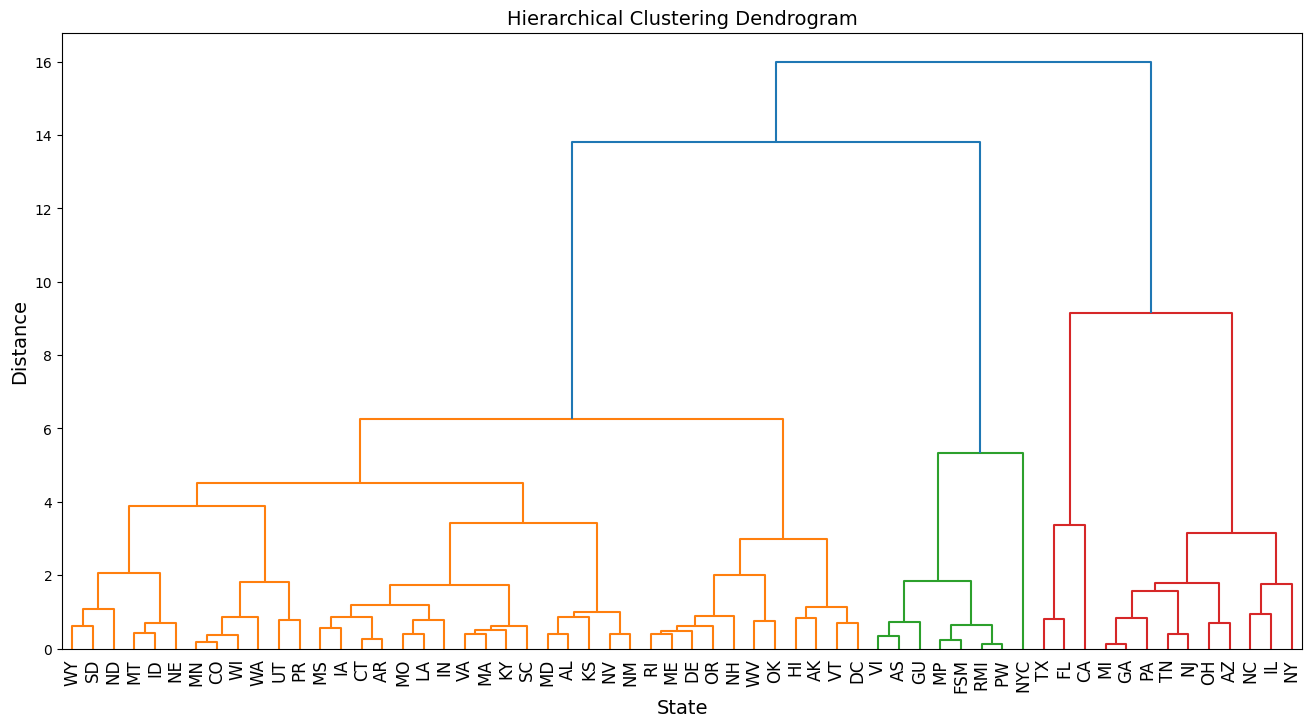

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

# OLD version needs to be updated
covid_data = pd.read_csv("death_sero.csv")
print("Dataset shape:", covid_data.shape)


# Create state-level aggregates
state_aggregates = covid_data.groupby('state').agg({
    'tot_cases': 'max',
    'tot_deaths': 'max', 
    'n_samples': 'mean',
    'n_infected': 'mean'
}).reset_index()

# Fill NaN values with 0 for clustering
state_aggregates = state_aggregates.fillna(0)

# Create additional features
state_aggregates['case_fatality_rate'] = np.where(
    state_aggregates['tot_cases'] > 0, 
    state_aggregates['tot_deaths'] / state_aggregates['tot_cases'], 
    0
)

state_aggregates['infection_rate'] = np.where(
    state_aggregates['n_samples'] > 0,
    state_aggregates['n_infected'] / state_aggregates['n_samples'],
    0
)

# Select features for clustering
covid_related = state_aggregates[[
    'tot_cases',
    'tot_deaths', 
    'case_fatality_rate',
    'n_samples',
    'n_infected',
    'infection_rate'
]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)

model = AgglomerativeClustering(n_clusters=6)
model.fit(scaled_features)

labels = model.labels_  

# Scatterplot
x = covid_related['tot_cases']
y = covid_related['tot_deaths']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=labels, cmap='viridis', s=100)

plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Agglomerative Clustering of States (6 Clusters)')
plt.colorbar(label='Cluster')
plt.xscale('log')
plt.yscale('log')

# dendrogram
linked = linkage(scaled_features, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linked,
           labels=state_aggregates['state'].values,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=12)

plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.xticks(rotation=90)

# Calculate silhouette score
score = silhouette_score(scaled_features, labels)
print("Agglomerative Clustering Silhouette Score:", score)

In [55]:
# Does a high unvaccinated infection rate predict an unacceptable death level?

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [57]:
#Uploading the data
death_sero_data = pd.read_csv('death_sero.csv')
vaccine_data = pd.read_csv('vaccine.csv')

print(death_sero_data.head())
print(vaccine_data.head())

  state  tot_cases  tot_deaths year_week  n_samples  n_infected
0    AK        0.0         0.0  2020-W03        NaN         NaN
1    AK        0.0         0.0  2020-W04        NaN         NaN
2    AK        0.0         0.0  2020-W05        NaN         NaN
3    AK        0.0         0.0  2020-W06        NaN         NaN
4    AK        0.0         0.0  2020-W07        NaN         NaN
  outcome  boosted_with_outcome  boosted_population  \
0    case                   546             1562854   
1    case                   624             1898762   
2    case                   746             2315541   
3    case                   896             3983836   
4    case                  1196             5945158   

   primary_series_only_with_outcome  primary_series_only_population  \
0                            107943                       111647895   
1                            102107                       112762094   
2                             96205                       113676350   
3

In [58]:
#Checking for missing data
print(death_sero_data.isnull().sum())
print(vaccine_data.isnull().sum()) 

state            0
tot_cases       99
tot_deaths      99
year_week        0
n_samples     8134
n_infected    8134
dtype: int64
outcome                             0
boosted_with_outcome                0
boosted_population                  0
primary_series_only_with_outcome    0
primary_series_only_population      0
unvaccinated_with_outcome           0
unvaccinated_population             0
crude_booster_ir                    0
crude_primary_series_only_ir        0
crude_unvax_ir                      0
crude_booster_irr                   0
crude_irr                           0
age_adj_booster_ir                  0
age_adj_vax_ir                      0
age_adj_unvax_ir                    0
age_adj_booster_irr                 0
age_adj_irr                         0
year_week                           0
dtype: int64


In [59]:
#Dropping missing data for the model
death_sero_data_filtered = death_sero_data.dropna(subset=['tot_cases', 'tot_deaths'])
#Merged the datasets to give each state week a set of vaccine features that are the same across all states per week
dseroandvac_data = pd.merge(death_sero_data_filtered, vaccine_data, on = 'year_week', how = 'left')
#Sorting 
dseroandvac_data = dseroandvac_data.sort_values(by=['state', 'year_week'])
# Compute weekly deaths per state
dseroandvac_data['weekly_deaths'] = dseroandvac_data.groupby('state')['tot_deaths'].diff().fillna(0)
#Estimate deaths per 100k using estimated population
dseroandvac_data['deaths_per_100k'] = (dseroandvac_data['weekly_deaths'] / 5000000) * 100000
# Binary label: 1 = unacceptable if >= 1 death/100k, else 0
dseroandvac_data['unacceptable'] = (dseroandvac_data['deaths_per_100k'] >= 1).astype(int)
# Drop rows with missing data
model_data = dseroandvac_data.dropna(subset=['crude_unvax_ir', 'unacceptable'])
# Predictor and target
X = model_data[['crude_unvax_ir', 'age_adj_unvax_ir', 'crude_booster_ir', 'age_adj_booster_ir', 'crude_irr', 'age_adj_irr']]
y = model_data.loc[X.index, 'unacceptable']

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

model = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7338187702265372
Confusion Matrix:
 [[605 322]
 [  7 302]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.65      0.79       927
           1       0.48      0.98      0.65       309

    accuracy                           0.73      1236
   macro avg       0.74      0.81      0.72      1236
weighted avg       0.86      0.73      0.75      1236



In [60]:
# Steve adding in Population data
# Get populationn by state
nat_sero_pop = pd.read_csv("Nationwide_Commercial_Laboratory_Seroprevalence_Survey.csv")
nat_sero_pop.rename(columns={'Site': 'state', 'Catchment population': 'state_population'}, inplace=True)
nat_sero_pop = nat_sero_pop[nat_sero_pop["Catchment Area Description"] == 'Statewide']
state_pop = nat_sero_pop.groupby('state')['state_population'].mean().reset_index()
display(state_pop.head(3))

# Join to the other data
sero_pop_state = dseroandvac_data.merge(state_pop, on='state', how='left')
sero_pop_state['sero_rate'] = sero_pop_state['n_infected'] / sero_pop_state['n_samples']
display(sero_pop_state.head(3))

# Clean up the data set a little
sero_pop_state['state_population'] = sero_pop_state['state_population'].fillna(0)
sero_pop_state = sero_pop_state.replace([None, np.nan, np.inf, -np.inf], 0)

# Create ratios/population for features
sero_pop_state['cases_per_100k'] = np.where(
    sero_pop_state['state_population'] > 0,
    (sero_pop_state['tot_cases'] / sero_pop_state['state_population']) * 100000, 0
)
sero_pop_state['deaths_per_100k'] = np.where(
    sero_pop_state['state_population'] > 0,
    (sero_pop_state['tot_deaths'] / sero_pop_state['state_population']) * 100000, 0
)
sero_pop_state['case_fatality_rate'] = np.where(
    sero_pop_state['tot_cases'] > 0, 
    sero_pop_state['tot_deaths'] / sero_pop_state['tot_cases'], 0
)
sero_pop_state['infection_rate'] = np.where(
    sero_pop_state['n_samples'] > 0,
    sero_pop_state['n_infected'] / sero_pop_state['n_samples'], 0
)
sero_pop_state.head(3)
print(sero_pop_state.columns)

,state,state_population
0,AK,6.578534e+05
1,AL,4.321031e+06
2,AR,2.660818e+06


,state,tot_cases,tot_deaths,year_week,n_samples,n_infected,outcome,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,...,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr,weekly_deaths,deaths_per_100k,unacceptable,state_population,sero_rate
0,AK,0.0,0.0,2020-W03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,657853.428571,NaN
1,AK,0.0,0.0,2020-W04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,657853.428571,NaN
2,AK,0.0,0.0,2020-W05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,657853.428571,NaN


Index(['state', 'tot_cases', 'tot_deaths', 'year_week', 'n_samples',
       'n_infected', 'outcome', 'boosted_with_outcome', 'boosted_population',
       'primary_series_only_with_outcome', 'primary_series_only_population',
       'unvaccinated_with_outcome', 'unvaccinated_population',
       'crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
       'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir',
       'age_adj_vax_ir', 'age_adj_unvax_ir', 'age_adj_booster_irr',
       'age_adj_irr', 'weekly_deaths', 'deaths_per_100k', 'unacceptable',
       'state_population', 'sero_rate', 'cases_per_100k', 'case_fatality_rate',
       'infection_rate'],
      dtype='object')


In [61]:
# Do we have per 100K data?
sero_pop_state[sero_pop_state["cases_per_100k"] > 0]

,state,tot_cases,tot_deaths,year_week,n_samples,n_infected,outcome,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,...,age_adj_booster_irr,age_adj_irr,weekly_deaths,deaths_per_100k,unacceptable,state_population,sero_rate,cases_per_100k,case_fatality_rate,infection_rate
8,AK,11.0,0.0,2020-W11,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0,657853.428571,0.0,1.672105,0.000000,0.0
9,AK,63.0,1.0,2020-W12,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.152010,0,657853.428571,0.0,9.576601,0.015873,0.0
10,AK,149.0,3.0,2020-W13,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.456029,0,657853.428571,0.0,22.649422,0.020134,0.0
11,AK,235.0,7.0,2020-W14,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,4.0,1.064067,0,657853.428571,0.0,35.722243,0.029787,0.0
12,AK,300.0,9.0,2020-W15,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.368086,0,657853.428571,0.0,45.602863,0.030000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13375,WY,186284.0,2023.0,2023-W15,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,3.0,391.085644,0,517278.000000,0.0,36012.356992,0.010860,0.0
13376,WY,186399.0,2027.0,2023-W16,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,4.0,391.858923,0,517278.000000,0.0,36034.588751,0.010875,0.0
13377,WY,186539.0,2030.0,2023-W17,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,3.0,392.438882,0,517278.000000,0.0,36061.653502,0.010882,0.0
13378,WY,186668.0,2031.0,2023-W18,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,392.632202,0,517278.000000,0.0,36086.591736,0.010880,0.0


In [62]:
X
X[X[(X > 1e308) | np.isinf(X)].any(axis=1)]

,crude_unvax_ir,age_adj_unvax_ir,crude_booster_ir,age_adj_booster_ir,crude_irr,age_adj_irr


In [67]:
covid_related
scaled_features

array([[-0.36465494, -0.2742615 , -0.3087507 , ..., -1.20434621,
        -1.07237744, -0.18230542],
       [-0.36465494, -0.2742615 , -0.3087507 , ..., -1.20434621,
        -1.07237744, -0.18230542],
       [-0.36465494, -0.2742615 , -0.3087507 , ..., -1.20434621,
        -1.07237744, -0.18230542],
       ...,
       [-0.36465494, -0.2742615 , -0.3087507 , ...,  1.46302749,
        -0.29405705, -0.18230542],
       [-0.36465494, -0.2742615 , -0.3087507 , ...,  1.4648721 ,
        -0.29421178, -0.18230542],
       [-0.36465494, -0.2742615 , -0.3087507 , ...,  1.47010564,
        -0.29573454, -0.18230542]])

In [71]:
X_cols = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
        'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir',
        'age_adj_vax_ir', 'age_adj_unvax_ir', 'age_adj_booster_irr',
        'age_adj_irr', 'weekly_deaths', 'deaths_per_100k', 'unacceptable',
        'state_population', 'sero_rate', 'cases_per_100k', 'case_fatality_rate',
        'infection_rate']
for col in X_cols:
    sero_pop_state[col] = sero_pop_state[col].fillna(0)

covid_related = sero_pop_state[X_cols]
X = pd.DataFrame(covid_related, columns=covid_related.columns, index=covid_related.index)
y = sero_pop_state.loc[X.index, 'unacceptable']

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

model = LogisticRegression(class_weight = 'balanced', max_iter = 5000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9147982062780269
Confusion Matrix:
 [[1608  194]
 [  34  840]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      1802
           1       0.81      0.96      0.88       874

    accuracy                           0.91      2676
   macro avg       0.90      0.93      0.91      2676
weighted avg       0.92      0.91      0.92      2676



S:\code\uw\IMT574\py39_venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
X_cols = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
        'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir',
        'age_adj_vax_ir', 'age_adj_unvax_ir', 'age_adj_booster_irr',
        'age_adj_irr', 'weekly_deaths', 'deaths_per_100k', 'unacceptable',
        'state_population', 'sero_rate', 'cases_per_100k', 'case_fatality_rate',
        'infection_rate']
for col in X_cols:
    sero_pop_state[col] = sero_pop_state[col].fillna(0)

covid_related = sero_pop_state[X_cols]
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)

X = pd.DataFrame(scaled_features, columns=covid_related.columns, index=covid_related.index)
y = sero_pop_state.loc[X.index, 'unacceptable']

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

model = LogisticRegression(class_weight = 'balanced', max_iter = 50)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion Matrix:
 [[1802    0]
 [   0  874]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1802
           1       1.00      1.00      1.00       874

    accuracy                           1.00      2676
   macro avg       1.00      1.00      1.00      2676
weighted avg       1.00      1.00      1.00      2676



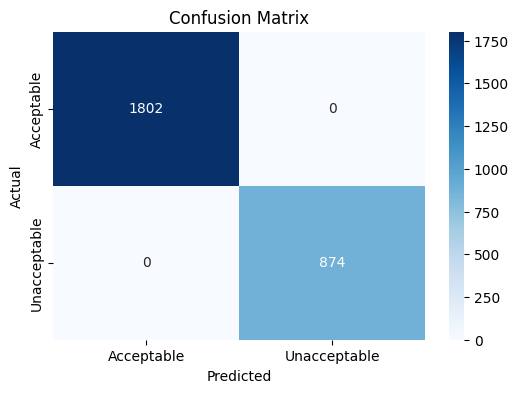

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Acceptable', 'Unacceptable'], yticklabels = ['Acceptable', 'Unacceptable'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [66]:
# Problem Statement
# Does a high unvaccinated infection rate predict an unacceptable COVID-19 death level in a given week?

# Data sources:
# death_sero.csv Weekly state level cumulative COVID-19 deaths and seroprevalence.
# vaccine.csv National level infection rates by vaccination status for each week. 

# We calculated weekly deaths by differencing the cumulative totals. Then, we created a normalized measure: deaths per 100,000 population, defined a 
# binary label unacceptable, where 1 represents a week with more than 1 death per 100,000 population, and cleaned rows with missing data for key 
# predictor fields.

# The predictor variables selected for the logistic regression model were:
# crude_unvax_ir: The infection rate among the unvaccinated
# age_adj_unvax_ir: Age-adjusted infection rate among the unvaccinated
# crude_booster_ir: Infection rate among boosted
# age_adj_booster_ir: Age-adjusted infection rate among the boosted
# crude_irr: Infection rate ratio (unvax vs booster)
# age_adj_irr: Age-adjusted infection rate ratio

# To find an answer to our problem statement, we used logistic regression with class_weight = 'balance' to compensate for the class imbalance. In our 
# dataset, the majority of weeks were classified as "acceptable" (fewer than 1 death per 100,000), while only a small fraction were classified as 
# "unacceptable." This imbalance can cause a standard logistic regression model to become biased toward predicting the majority class, thereby missing 
# critical high-risk periods. By applying class weights, the model places more importance on correctly identifying the minority class (unacceptable weeks),
# ensuring that the model is accurate overall and sensitive to the most dangerous scenarios.

# Logistic Regression Model Evaluation
# Accuracy: 73% 

# Confusion Matrix:
    # True Negatives: 605
    # False Positives: 322
    # False Negatives: 7
    # True Positives: 302

# Precision (Unacceptable): 0.48
# Recall (Unacceptable): 0.98

# The overall accuracy is 73%, but this metric can be misleading in class imbalance. Since most weeks fall into the "acceptable" category, a model 
# could achieve high accuracy by mainly predicting that class without truly identifying high-risk periods. Instead, we focus on recall, which measures
# how well the model detects unacceptable (high-death) weeks. Our recall of 0.98 means we correctly identified nearly all high-death weeks as a critical
# requirement in a public health context. Precision is lower (0.48), indicating some false alarms, but in a healthcare setting, false positives are more
# tolerable than false negatives. Thus, our model prioritizes sensitivity to dangerous situations over raw accuracy.

# Interpretations
# Our model suggests that high unvaccinated infection rates are strongly associated with weeks of rising deaths due to COVID-19. The trend could mean that
# infections among the unvaccinated population can serve as an indicator for increased mortality risk. The model can help health institutions adjust their
# allocation of resources more effectively and efficiently when COVID-19 deaths are on the rise. 

# Limitations
# Our data does not include population counts, limiting the precision of death rate calculations.
# State-level vaccine behavior was assumed to match national-level trends.
# Logistic regression was chosen for its interpretability, but more complex models (e.g., random forests) may improve accuracy.


# Our logistic regression model effectively identifies weeks with unacceptable COVID-19 death rates based on infection trends. Although precision 
# remains a challenge, the model offers valuable early-warning potential for healthcare planning.

